# Naive Bayes

In [21]:
import numpy as np 
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

### Input data
../train.csv                  7613   
../test.csv                   3263   
../sample_submission.csv      3263   

In [25]:
train_df = pd.read_csv("../train.csv")
test_df = pd.read_csv("../test.csv")
sub_df = pd.read_csv("../sample_submission.csv")
print (train_df.shape, test_df.shape, sub_df.shape)

(7613, 5) (3263, 4) (3263, 2)


In [8]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


There is no duplicated data

In [26]:
train_df.duplicated().sum()

0

### The train set distribution

0    4342
1    3271
Name: target, dtype: int64

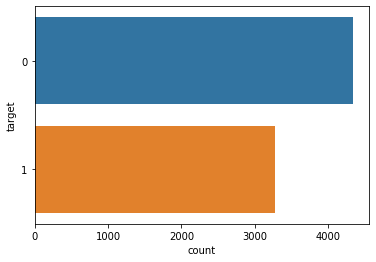

In [23]:
train_df = train_df.drop_duplicates().reset_index(drop=True)
sns.countplot(y=train_df.target);
train_df.target.value_counts()

### Separate the train.csv into 80% train data and 20% test data.

In [27]:
x = train_df["text"]
y = train_df["target"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [28]:
X_train.head()

4996    Courageous and honest analysis of need to use ...
3263    @ZachZaidman @670TheScore wld b a shame if tha...
4907    Tell @BarackObama to rescind medals of 'honor'...
2855    Worried about how the CA drought might affect ...
4716    @YoungHeroesID Lava Blast &amp; Power Red #Pan...
Name: text, dtype: object

### Get stopword in sklearn.   
CountVectorizer(stop_words = 'english')

In [9]:
vect = CountVectorizer(stop_words = 'english')

x_train_cv = vect.fit_transform(X_train)
x_test_cv = vect.transform(X_test)

In [12]:
clf = MultinomialNB()
clf.fit(x_train_cv, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [13]:
pred = clf.predict(x_test_cv)
confusion_matrix(y_test, pred)

array([[735, 139],
       [185, 464]])

In [14]:
accuracy_score(y_test,pred)

0.7872619829284307

In [15]:
y_test = test_df["text"]
y_test_cv = vect.transform(y_test)
preds = clf.predict(y_test_cv)
sub_df["target"] = preds
sub_df.to_csv("submission_bayes.csv",index=False)